## Demo of how the risk factors are generated. Hyperparameters are not necessarily reasonable. For the number of risk factors, we set K=3. And for the number of bonds, we set m=10.

In [31]:
from bond_portfolio_gen import *
from MFM_constructor import *
from utils import seed_all, naive_kernel_estimator
from scipy.stats import ortho_group
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


seed_all(10)

K = 3
m = 10

N = 365

r_LO, r_HI = (0.02, 0.06)
f_LO, f_HI = (-0.01, 0.01)
lam_LO, lam_HI = (0, 1e-6)
S_LO, S_HI = (1., 5.)


sig_eps = 1e-5
alpha = 0.5
n_dependence = 2
wei = np.array([alpha, alpha**2])
Gamma = ortho_group.rvs(m)[:,:K]
eig_Lambda = np.random.uniform(lam_LO,lam_HI,K)
S_mature = np.random.uniform(S_LO, S_HI, m)
positions = np.ones(m)/m


# interest rate r will mostly in range 0 - 6

r_mat = np.zeros((N+1, m))
b_val = np.zeros(N+1)
f_mat = np.zeros((N, K))

r_mat[0] = np.random.uniform(r_LO, r_HI, m)
b_val[0] = Bond_PortVal(r_mat[0], S_mature, positions)

for i in range(N):
    
    if i <= 1:
        f = np.random.uniform(f_LO, f_HI, K)
    else :
        f = risk_factor_generator(
            f_mat[i-n_dependence:i], 
            AR_effect_F,
            noise_diagLambda_F,
            FE_Args(weights = wei),
            NOI_Args(eig_vals = eig_Lambda)
        )
    
    f_mat[i] = f
    
    q = q_generator(
        f,
        Gamma,
        noise_iid_F,
        NOI_Args(sigma = sig_eps)
    )
    
    r = np.clip(r_mat[i] + q, a_min = 0, a_max = 1)
    
    r_mat[i+1] = r
    
    b_val[i+1] = Bond_PortVal(r_mat[i+1], S_mature, positions)
    
    
r_mat = r_mat[1:]
b_val = b_val[1:]


Z_data, Y_data = MFM_Bond_dataConstruct(
    b_val,
    r_mat,
    f_mat,
    n_dependence
)

Z_data = normalize(Z_data, axis = 0)

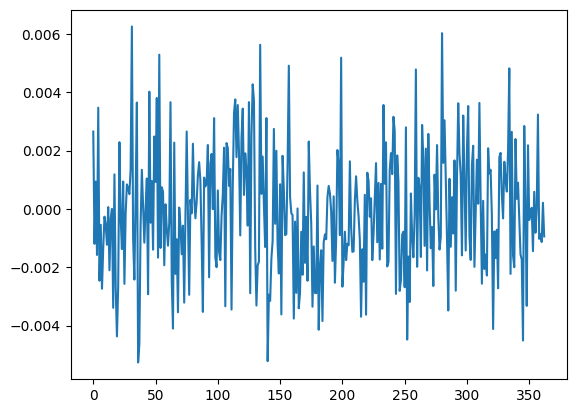

In [32]:
plt.plot(Y_data)

## To manually create confidence intervals, we sample multiple Y vals

In [33]:
N_sample = 100
quant_interval_alpha = 0.1

sample_holder = np.zeros((N, N_sample))

for j in range(n_dependence, N):
    
    r_hist = r_mat[j - 1]
    f_dep = f_mat[j-n_dependence : j]
    
    samples = np.zeros(N_sample)
    
    for jj in range(N_sample):
        new_factor = risk_factor_generator(
            f_dep, 
            AR_effect_F,
            noise_diagLambda_F,
            FE_Args(weights = wei),
            NOI_Args(eig_vals = eig_Lambda)
        )
        
        new_q = q_generator(
            new_factor,
            Gamma,
            noise_iid_F,
            NOI_Args(sigma = sig_eps)
        )
        
        new_r = np.clip(r_hist + new_q, a_min = 0, a_max = 1)
        new_b = Bond_PortVal(new_r, S_mature, positions)
    
        samples[jj] = new_b - b_val[j-1]
    
    
    sample_holder[j] = samples
    

sample_holder = np.sort(sample_holder)
lower = sample_holder[:, int(N_sample * quant_interval_alpha /2)]
upper = sample_holder[:, int(N_sample - N_sample * quant_interval_alpha /2)]

lower = lower[n_dependence:]
upper = upper[n_dependence:]

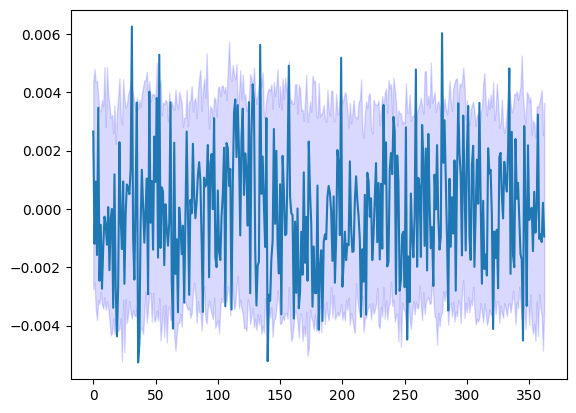

In [34]:
fig, ax = plt.subplots()
x = np.arange(len(Y_data))

ax.plot(x, Y_data)
ax.fill_between(
    x, lower, upper, color='b', alpha=.15)

## plot the violations

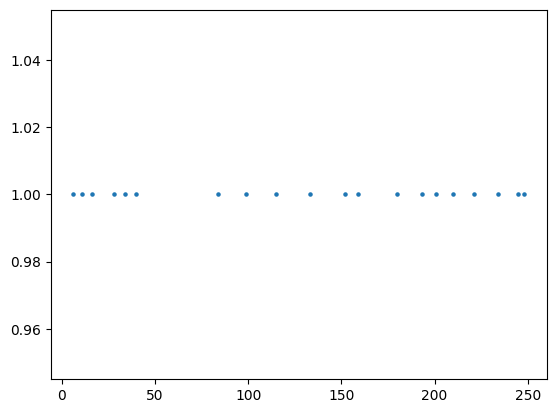

In [35]:
starting = 100

vio = ((Y_data > upper) | (Y_data < lower)).astype(int)

vio = vio[starting:]

vio_poses = np.where(vio > 0)[0]

scalas = [1] * len(vio_poses)

fig, ax = plt.subplots()

ax.scatter(vio_poses, scalas, s=5)

In [36]:
print(vio_poses)

[  6  11  16  28  34  40  84  99 115 133 152 159 180 193 201 210 221 234
 245 248]


In [37]:
## empirical violation percentage

print(len(vio_poses) / len(vio))

0.07604562737642585


## Now we use our kernel estimator to reproduce confidence intervals. We follow a back testing procedure

In [38]:
from utils import naive_kernel_estimator, rbf_kernel_estimator

width = 1E-1

ker_lower = np.zeros(len(Y_data))
ker_upper = np.zeros(len(Y_data))

starting = 100

ker_lower[:starting] = Y_data[:starting]
ker_upper[:starting] = Y_data[:starting]

for i in range(starting, len(Y_data)):
    
    recal_Z = Z_data[:i]
    
    recal_Y = Y_data[:i]
    
    test_Z = Z_data[i:i+1]
    
    quants = rbf_kernel_estimator(
        test_Z,
        recal_Z,
        recal_Y,
        quants = np.array([quant_interval_alpha/2, 1-quant_interval_alpha/2]),
        wid = width,
    )
    
    ker_lower[i] = quants[0, 0]
    ker_upper[i] = quants[1, 0]

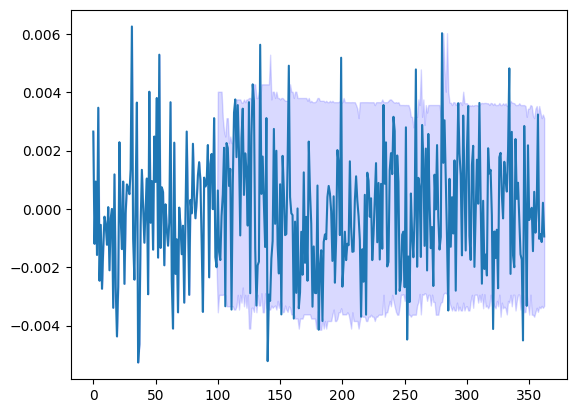

In [39]:
fig, ax = plt.subplots()
x = np.arange(len(Y_data))

ax.plot(x, Y_data)
ax.fill_between(
    x, ker_lower, ker_upper, color='b', alpha=.15)

## plot the violations

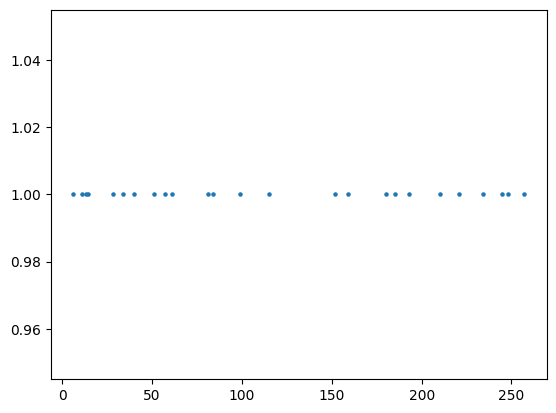

In [40]:
ker_vio = ((Y_data > ker_upper) | (Y_data < ker_lower)).astype(int)

ker_vio = ker_vio[starting:]

ker_vio_poses = np.where(ker_vio > 0)[0]

scalas = [1] * len(ker_vio_poses)

fig, ax = plt.subplots()

ax.scatter(ker_vio_poses, scalas, s=5)

In [41]:
print(ker_vio_poses)

[  6  11  13  14  28  34  40  51  57  61  81  84  99 115 152 159 180 185
 193 210 221 234 245 248 257]


In [42]:
## empirical violation percentage

print(len(ker_vio_poses) / len(ker_vio))

0.09505703422053231


## To achieve calibration for scenario analysis, we reconstruct the dataset

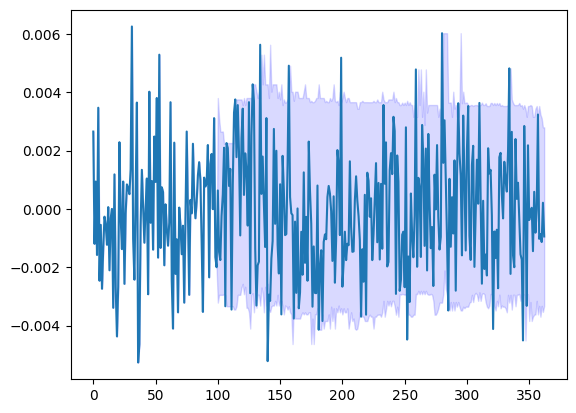

In [43]:
Z_X_data, _ = EMFM_Bond_dataConstruct(
    b_val,
    r_mat,
    f_mat,
    n_dependence,
    A_stress = np.array([
        [1,0,0],
        [0,1,0]
    ])
)

Z_X_data = normalize(Z_X_data, axis = 0)


scenario_kerWidth = 1E-1

scenario_ker_lower = np.zeros(len(Y_data))
scenario_ker_upper = np.zeros(len(Y_data))

scenario_ker_lower[:starting] = Y_data[:starting]
scenario_ker_upper[:starting] = Y_data[:starting]

for i in range(starting, len(Y_data)):
    
    scenario_recal_Z = Z_X_data[:i]
    
    scenario_recal_Y = Y_data[:i]
    
    scenario_test_Z = Z_X_data[i:i+1]
    
    scenario_quants = rbf_kernel_estimator(
        scenario_test_Z,
        scenario_recal_Z,
        scenario_recal_Y,
        quants = np.array([quant_interval_alpha/2, 1-quant_interval_alpha/2]),
        wid = scenario_kerWidth,
    )
    
    scenario_ker_lower[i] = scenario_quants[0, 0]
    scenario_ker_upper[i] = scenario_quants[1, 0]
    

fig, ax = plt.subplots()

ax.plot(x, Y_data)
ax.fill_between(
    x, scenario_ker_lower, scenario_ker_upper, color='b', alpha=.15)

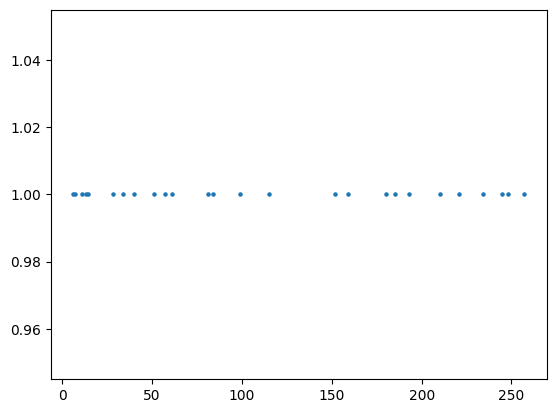

In [44]:
scenario_ker_vio = ((Y_data > scenario_ker_upper) | (Y_data < scenario_ker_lower)).astype(int)

scenario_ker_vio = scenario_ker_vio[starting:]

scenario_ker_vio_poses = np.where(scenario_ker_vio > 0)[0]

scenario_scalas = [1] * len(scenario_ker_vio_poses)

fig, ax = plt.subplots()

ax.scatter(scenario_ker_vio_poses, scenario_scalas, s=5)

In [45]:
## empirical violation percentage

print(len(scenario_ker_vio_poses) / len(scenario_ker_vio))

0.09885931558935361


## A demo of the output of calibration for scenario analysis

In [54]:
pick_index = 200
stress_1_list = [-1e-1, 0, 1e-1]
stress_2_list = [-2e-2, -1e-2, 0, 1e-2, 2e-2]

lower_mat = np.zeros((len(stress_1_list),len(stress_2_list)))
upper_mat = np.zeros((len(stress_1_list),len(stress_2_list)))

for i in range(len(stress_1_list)):
    for j in range(len(stress_2_list)):
        stress = np.array([stress_1_list[i],stress_2_list[j]])
        
        factor_s = Z_data[pick_index]
        
        cat = np.concatenate((stress, factor_s)).reshape(1,-1)
        
        
        example_recal_Z = Z_X_data[:pick_index]
    
        example_recal_Y = Y_data[:pick_index]

        example_test_Z = cat

        example_quants = rbf_kernel_estimator(
            example_test_Z,
            example_recal_Z,
            example_recal_Y,
            quants = np.array([quant_interval_alpha/2, 1-quant_interval_alpha/2]),
            wid = scenario_kerWidth,
        )

        lower_mat[i,j] = example_quants[0, 0]
        upper_mat[i,j] = example_quants[1, 0]
        
print(lower_mat)
print(upper_mat)
        

[[-0.00361747 -0.00361747 -0.00361747 -0.00361747 -0.00354517]
 [-0.00361747 -0.00361747 -0.00354517 -0.00354517 -0.00354517]
 [-0.00384365 -0.00361747 -0.00361747 -0.00361747 -0.00361747]]
[[0.00365551 0.00364343 0.00364343 0.00364343 0.00364343]
 [0.00380052 0.00380052 0.00380052 0.00380052 0.00375091]
 [0.00380052 0.00380052 0.00380052 0.00375091 0.00370407]]


In [55]:
print(Z_X_data[pick_index][:2])

[-0.01185684 -0.01440761]


In [56]:
print(Y_data[pick_index])

-0.002666614925915023
